In [90]:
import xarray as xr
import numpy as np

import datetime
import matplotlib.pyplot as plt
from utils import int_to_datetime

import glob

In [134]:
ports = {
    'churchill': (58.7745, -94.1935),
    'inukjuak': (58.4514, -78.1351),
    'quaqtaq': (61.0442, -69.6421),
    # 'sanirajak': (),
}
ds = xr.open_mfdataset(glob.glob('data/hb_era5_glorys_nc/*.nc'))
mask = np.isnan(ds.siconc.isel(time=0))

results_dir = 'ice_results_may7_exp_0'

months = list(range(1, 13))
ds_pred = []
for month in months:
    try:
        ds_pred.append(xr.open_dataset(f'{results_dir}/valpredictions_M{month}_Y2011_Y2015_I10O90.nc', engine='netcdf4'))
    except Exception as e: #FileNotFoundError:
        print(e)
        pass
    
ds_pred = xr.concat(ds_pred, dim='launch_date')
ds_pred = ds_pred.rio.set_crs(4326)
ds_pred['launch_date'] = [int_to_datetime(dt) for dt in ds_pred.launch_date.values]

ds = ds.isel(time=slice(0, -1))
ds_pred = ds_pred.isel(launch_date=slice(0, -1))

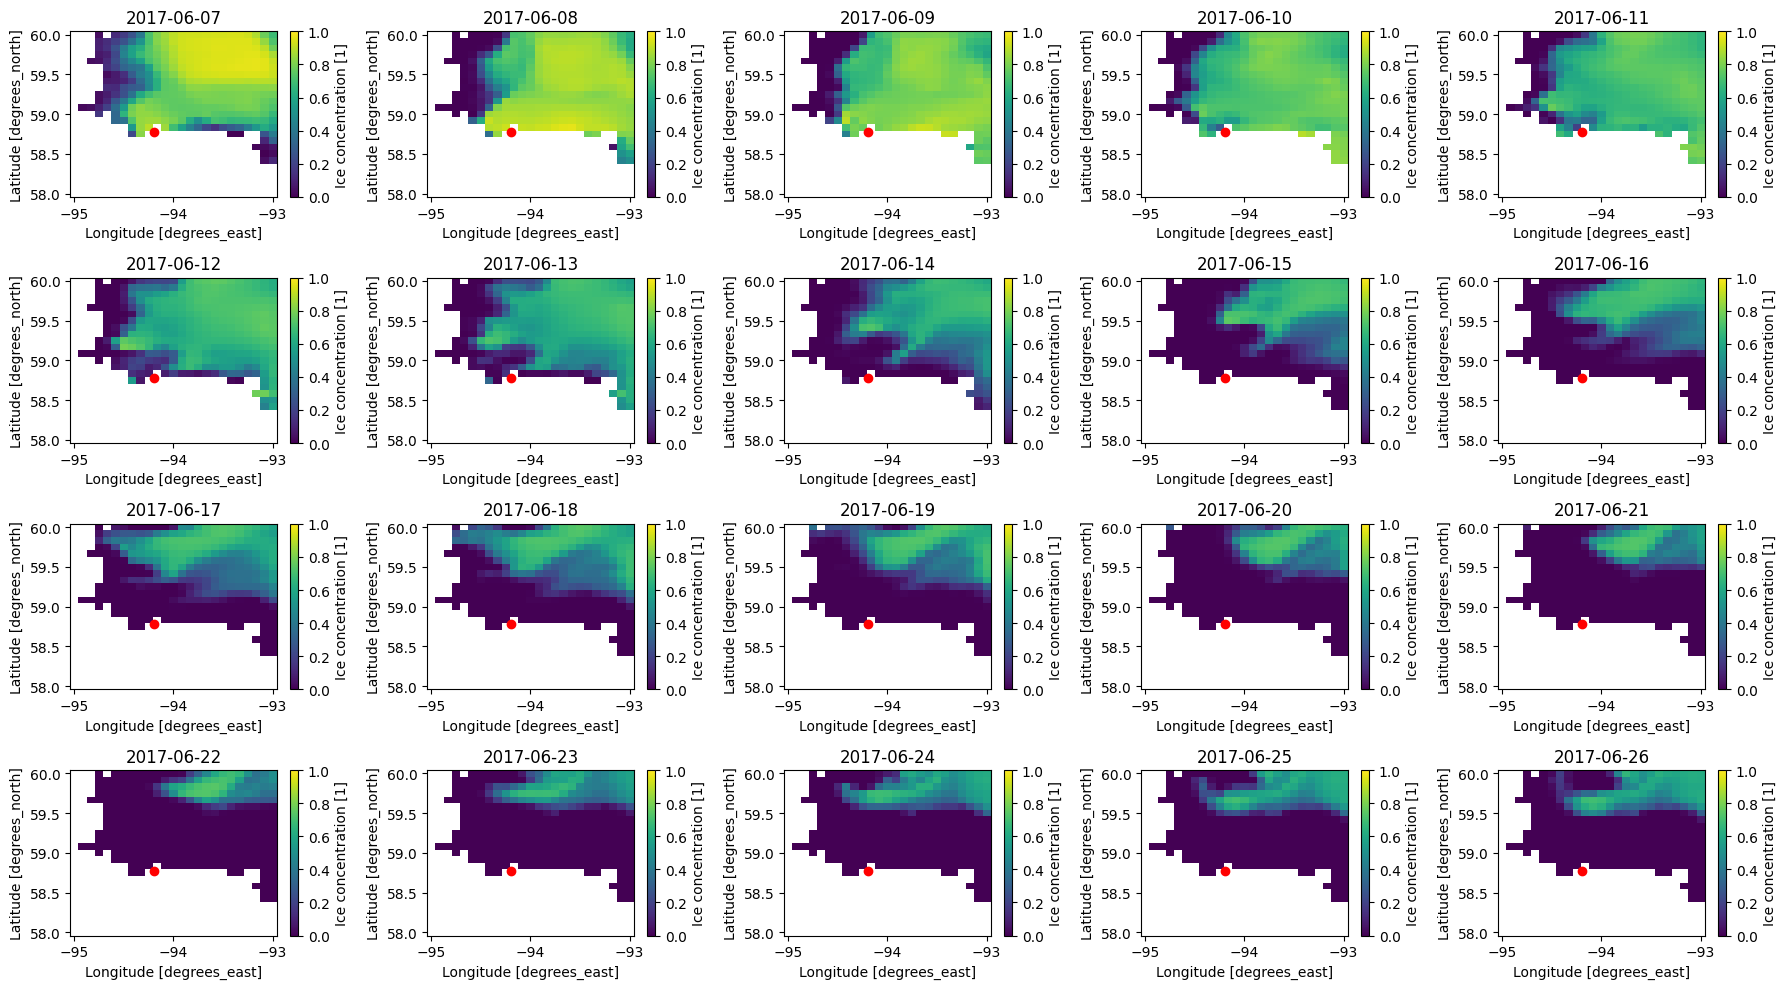

In [145]:
ds_ch = ds.sel(latitude=slice(58, 60), longitude=slice(-95, -93))
mask_ch = mask.sel(latitude=slice(58, 60), longitude=slice(-95, -93))
ds_ch = ds_ch.sel(time=slice(datetime.datetime(2017, 6, 7), datetime.datetime(2017, 6, 7+19)))

fig, axs = plt.subplots(4, 5, figsize=(18, 10))
for i, t in enumerate(ds_ch.time.values):
    ds_ch.sel(time=t).fillna(0).where(~mask_ch).siconc.plot(vmin=0, vmax=1, ax=axs.flatten()[i])
    axs.flatten()[i].scatter(ports['churchill'][1], ports['churchill'][0], c='r')
    axs.flatten()[i].set_title(str(t)[:10])
plt.tight_layout()

In [108]:
def get_breakup_date(ds, port):
    lat = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['latitude'].values)
    lon = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['longitude'].values)

    lat_i, lon_i = np.argwhere(ds.latitude.values==lat)[0][0], np.argwhere(ds.longitude.values==lon)[0][0]

    ds_window = ds.isel(latitude=slice(lat_i-5, lat_i+5), longitude=slice(lon_i-5, lon_i+5)).siconc
    mask_window = mask.isel(latitude=slice(lat_i-5, lat_i+5), longitude=slice(lon_i-5, lon_i+5))
    ds_window = ds_window.fillna(0).where(~mask_window)
    proportion_ice = ((ds_window > 0.15).sum(['latitude', 'longitude']) / np.sum(~mask_window))

    years = np.unique(ds.time.dt.year)
    
    breakup_dates = {}
    for year in years:
        breakup_window = proportion_ice.sel(time=slice(datetime.datetime(year, 5, 15), datetime.datetime(year, 7, 15)))
        breakup_date = breakup_window.time[np.argwhere(breakup_window.values>0.3)[-1]]
        
        breakup_dates[year] = breakup_date.values
    return breakup_dates

def get_freezeup_date(ds, port):
    lat = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['latitude'].values)
    lon = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['longitude'].values)

    lat_i, lon_i = np.argwhere(ds.latitude.values==lat)[0][0], np.argwhere(ds.longitude.values==lon)[0][0]

    ds_window = ds.isel(latitude=slice(lat_i-5, lat_i+5), longitude=slice(lon_i-5, lon_i+5)).siconc
    mask_window = mask.isel(latitude=slice(lat_i-5, lat_i+5), longitude=slice(lon_i-5, lon_i+5))
    ds_window = ds_window.fillna(0).where(~mask_window)
    proportion_ice = ((ds_window > 0.15).sum(['latitude', 'longitude']) / np.sum(~mask_window))
    
    years = np.unique(ds.time.dt.year)
    
    freezeup_dates = {}
    for year in years:
        freezeup_window = proportion_ice.sel(time=slice(datetime.datetime(year, 10, 15), datetime.datetime(year, 12, 15)))
        freezeup_date = freezeup_window.time[np.argwhere(freezeup_window.values>0.3)[0]]
        
        freezeup_dates[year] = freezeup_date.values
    return freezeup_dates


ds_pred_15 = ds_pred.sel(timestep=15).rename({'launch_date': 'time', 'y_hat': 'siconc'})
ds_pred_30 = ds_pred.sel(timestep=30).rename({'launch_date': 'time', 'y_hat': 'siconc'})

get_breakup_date(ds_pred_15, 'churchill')
get_freezeup_date(ds_pred_15, 'churchill')

/Users/zach/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


IndexError: index -1 is out of bounds for axis 0 with size 0

In [150]:
ds

<xarray.Dataset>
Dimensions:    (time: 2929, latitude: 229, longitude: 361)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2017-12-31
  * longitude  (longitude) float32 -95.0 -94.92 -94.83 ... -65.17 -65.08 -65.0
    area       (latitude, longitude) float32 dask.array<chunksize=(229, 361), meta=np.ndarray>
    distx      (latitude, longitude) float32 dask.array<chunksize=(229, 361), meta=np.ndarray>
    disty      (latitude, longitude) float32 dask.array<chunksize=(229, 361), meta=np.ndarray>
  * latitude   (latitude) float32 51.0 51.08 51.17 51.25 ... 69.83 69.92 70.0
    depth      float32 0.494
Data variables:
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(366, 229, 361), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(366, 229, 361), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(366, 229, 361), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(366, 229, 361), meta=np.ndarray>
    sshf       (time, latitude, longitude) float32 dask.array<chunksize=(366, 229, 361), meta=np.ndarray>
Attributes: (12/24)
    Conventions:        CF-1.4
    bulletin_date:      2020-06-03 00:00:00
    bulletin_type:      operational
    comment:            CMEMS product
    domain_name:        GL12
    easting:            longitude
    ...                 ...
    northing:           latitude
    references:         http://www.mercator-ocean.fr
    source:             MERCATOR GLORYS12V1
    title:              daily mean fields from Global Ocean Physics Analysis ...
    z_max:              5727.917
    z_min:              0.494025

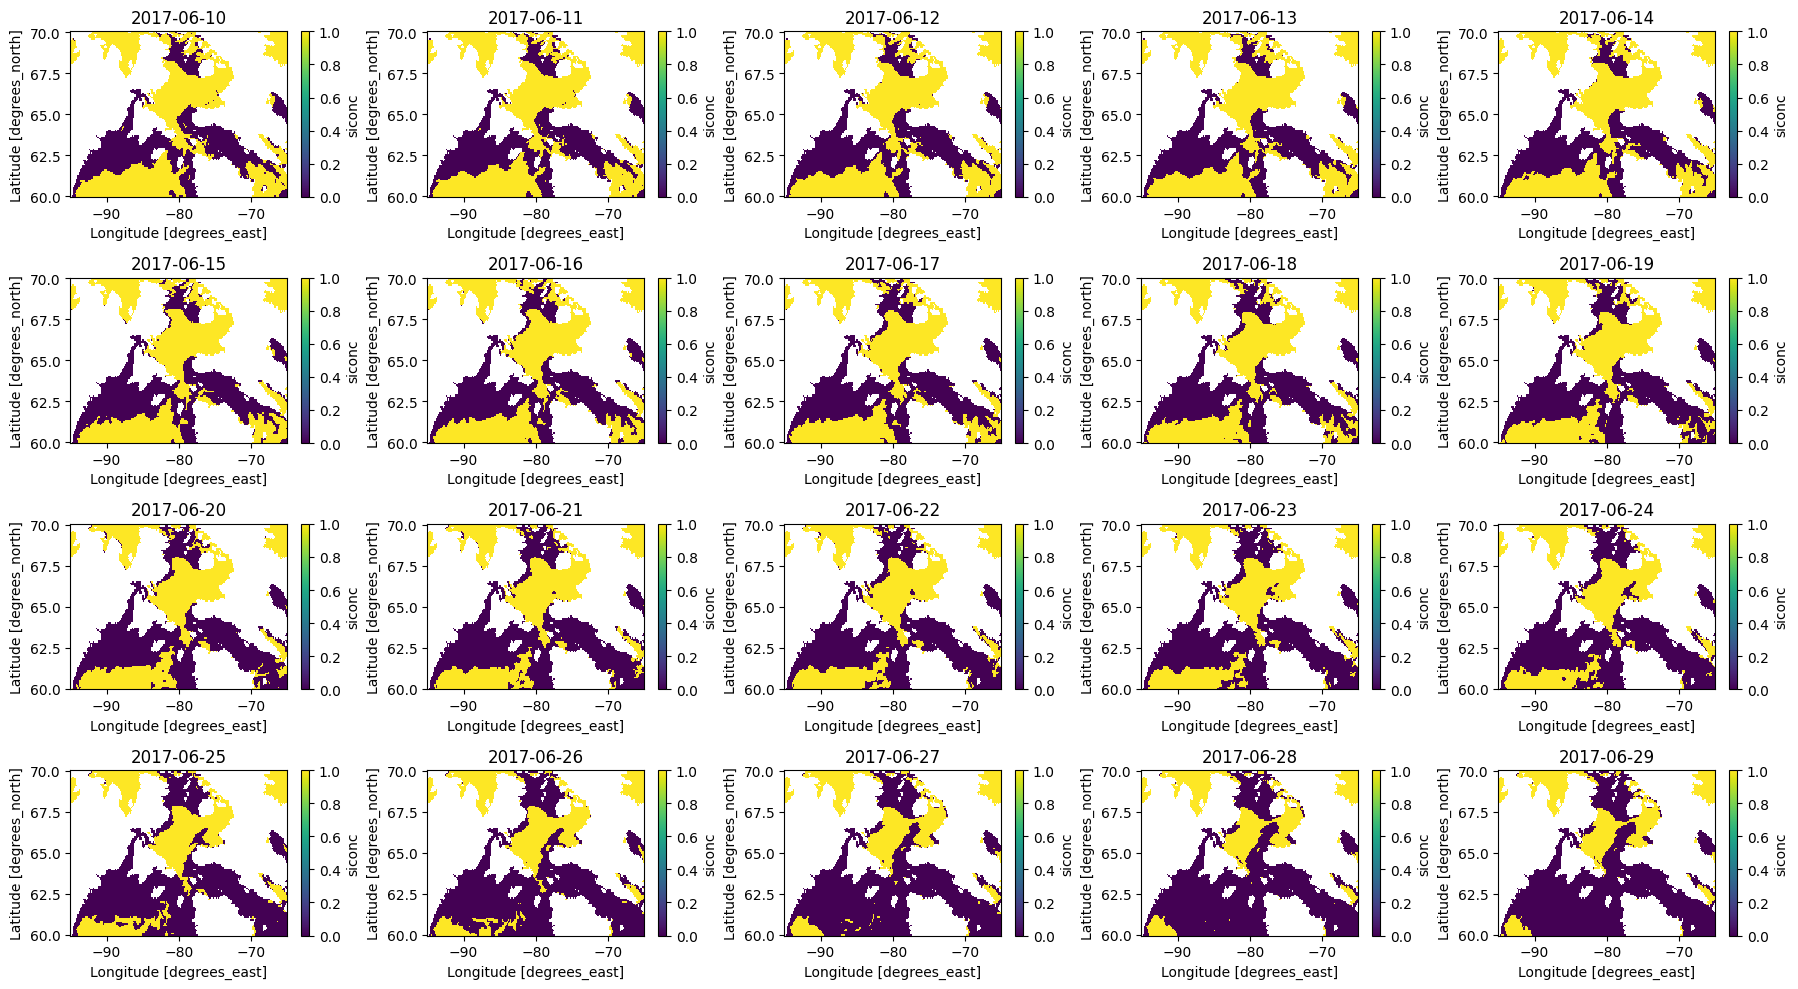

In [158]:
ds_ch = ds.sel(latitude=slice(60, 70), longitude=slice(-95, -65))
mask_ch = mask.sel(latitude=slice(60, 70), longitude=slice(-95, -65))
ds_ch = ds_ch.sel(time=slice(datetime.datetime(2017, 6, 10), datetime.datetime(2017, 6, 10+19)))

fig, axs = plt.subplots(4, 5, figsize=(18, 10))
for i, t in enumerate(ds_ch.time.values):
    (ds_ch.sel(time=t).fillna(0).siconc>0.15).where(~mask_ch).plot(vmin=0, vmax=1, ax=axs.flatten()[i])
    axs.flatten()[i].scatter(ports['churchill'][1], ports['churchill'][0], c='r')
    axs.flatten()[i].set_title(str(t)[:10])
plt.tight_layout()

In [118]:
ds.

<xarray.Dataset>
Dimensions:    (time: 368, latitude: 77, longitude: 121)
Coordinates:
  * longitude  (longitude) float32 -95.0 -94.75 -94.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 51.0 51.25 51.5 51.75 ... 69.5 69.75 70.0
  * time       (time) datetime64[ns] 2017-01-01T01:00:00 ... 2017-12-31T01:00:00
    timestep   int64 15
Data variables:
    siconc     (time, latitude, longitude) float32 nan nan nan ... 1.015 1.027
    y_true     (time, latitude, longitude) float32 0.0 0.0 0.0 ... 1.0 1.0 1.0

In [121]:
lon

-94.25

In [131]:
ds.isel(latitude=slice(lat_i-3, lat_i+3), longitude=slice(lon_i-3, lon_i+3))

<xarray.Dataset>
Dimensions:    (time: 368, latitude: 6, longitude: 6)
Coordinates:
  * longitude  (longitude) float32 -95.0 -94.75 -94.5 -94.25 -94.0 -93.75
  * latitude   (latitude) float32 58.0 58.25 58.5 58.75 59.0 59.25
  * time       (time) datetime64[ns] 2017-01-01T01:00:00 ... 2017-12-31T01:00:00
    timestep   int64 15
Data variables:
    siconc     (time, latitude, longitude) float32 nan nan nan ... 0.9379 0.9425
    y_true     (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.8135 0.8262

/Users/zach/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


IndexError: index 0 is out of bounds for axis 0 with size 0

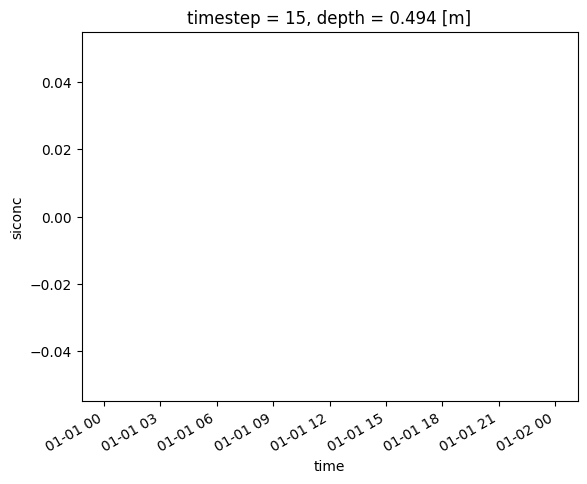

In [128]:
port = 'churchill'
lat = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['latitude'].values)
lon = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['longitude'].values)

lat_i, lon_i = np.argwhere(ds.latitude.values==lat)[0][0], np.argwhere(ds.longitude.values==lon)[0][0]

ds_window = ds.isel(latitude=slice(lat_i-3, lat_i+3), longitude=slice(lon_i-3, lon_i+3)).siconc
mask_window = mask.isel(latitude=slice(lat_i-3, lat_i+3), longitude=slice(lon_i-3, lon_i+3))
ds_window = ds_window.fillna(0).where(~mask_window)
proportion_ice = ((ds_window > 0.15).sum(['latitude', 'longitude']) / np.sum(~mask_window))

for year in range(2017, 2018):
    freezeup_window = proportion_ice.sel(time=slice(datetime.datetime(year, 10, 15), datetime.datetime(year, 12, 15)))
    freezeup_window.plot()
    freezeup_date = freezeup_window.time[np.argwhere(freezeup_window.values>0.3)[0]]
    plt.axvline([freezeup_date], c='r')
    plt.show()

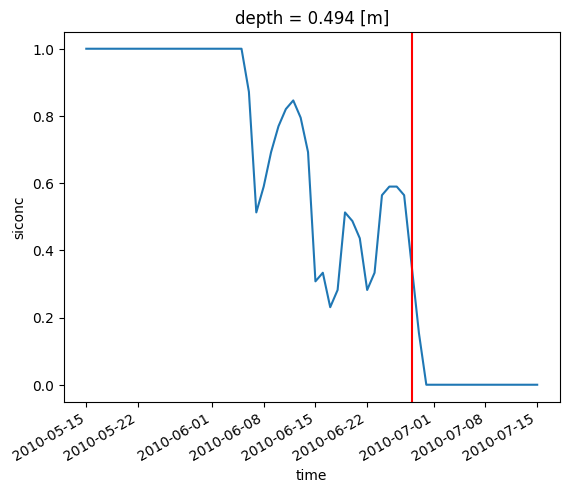

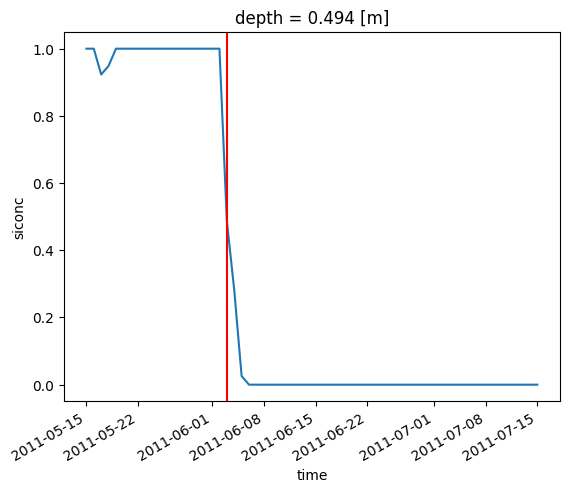

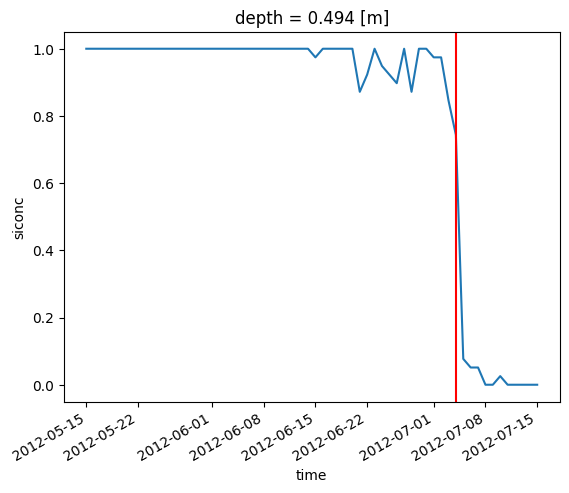

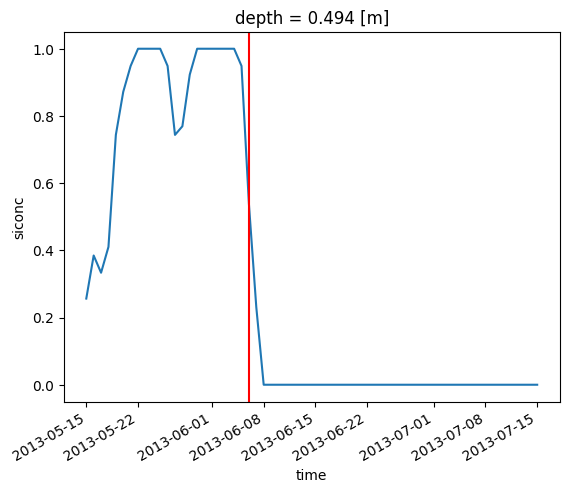

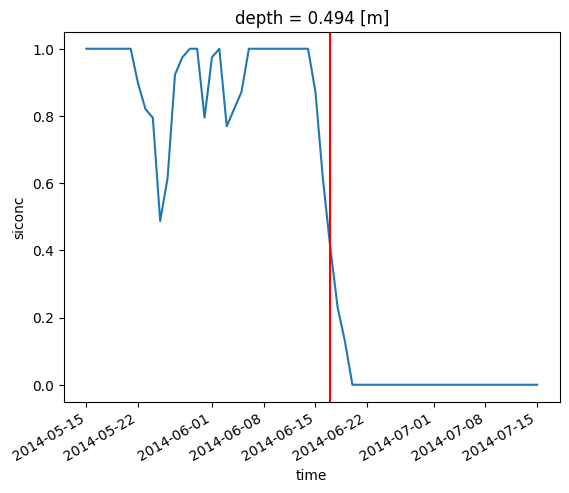

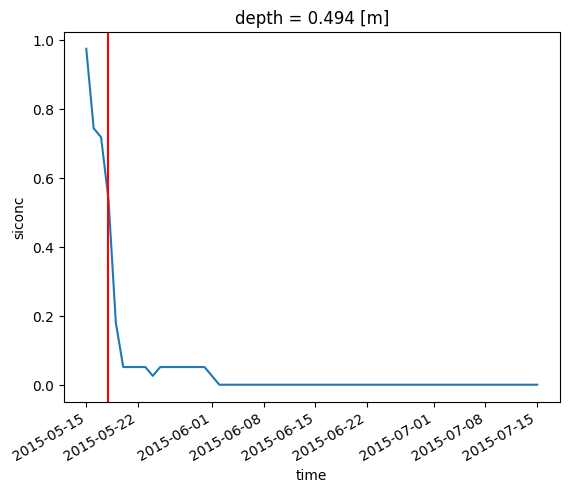

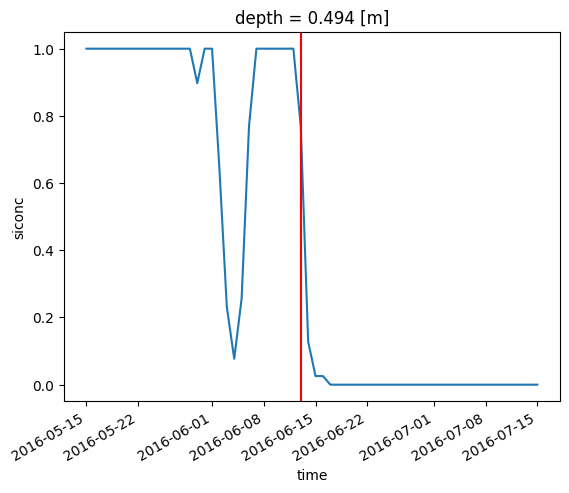

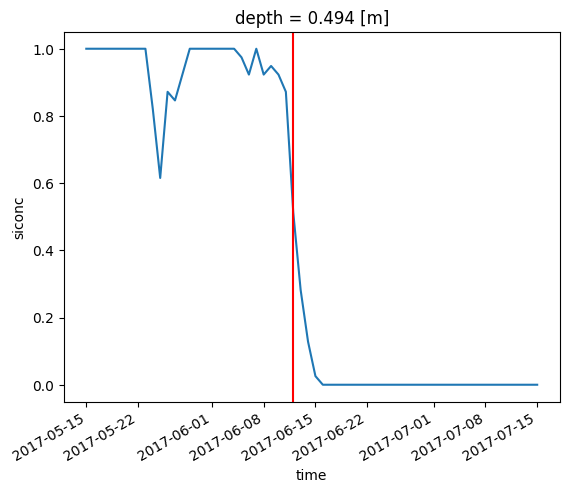

In [62]:
port = 'churchill'
lat = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['latitude'].values)
lon = float(ds.sel(latitude=ports[port][0], longitude=ports[port][1], method='nearest').coords['longitude'].values)

lat_i, lon_i = np.argwhere(ds.latitude.values==lat)[0][0], np.argwhere(ds.longitude.values==lon)[0][0]

ds_window = ds.isel(latitude=slice(lat_i-5, lat_i+5), longitude=slice(lon_i-5, lon_i+5)).siconc
mask_window = mask.isel(latitude=slice(lat_i-5, lat_i+5), longitude=slice(lon_i-5, lon_i+5))
ds_window = ds_window.fillna(0).where(~mask_window)
proportion_ice = ((ds_window > 0.15).sum(['latitude', 'longitude']) / np.sum(~mask_window))

for year in range(2010, 2018):
    breakup_window = proportion_ice.sel(time=slice(datetime.datetime(year, 5, 15), datetime.datetime(year, 7, 15)))
    breakup_window.plot()
    breakup_date = breakup_window.time[np.argwhere(breakup_window.values>0.3)[-1]]
    plt.axvline([breakup_date], c='r')
    plt.show()

<xarray.DataArray 'time' (time: 1)>
array(['2010-06-28T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2010-06-28
    depth    float32 0.494